In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import warnings

warnings.filterwarnings("ignore")

data_processed_dir = "../data/processed/"
file = "heatwaves_2010_2025_p98_sao_paulo.nc"
ds = xr.open_dataset(os.path.join(data_processed_dir, file))


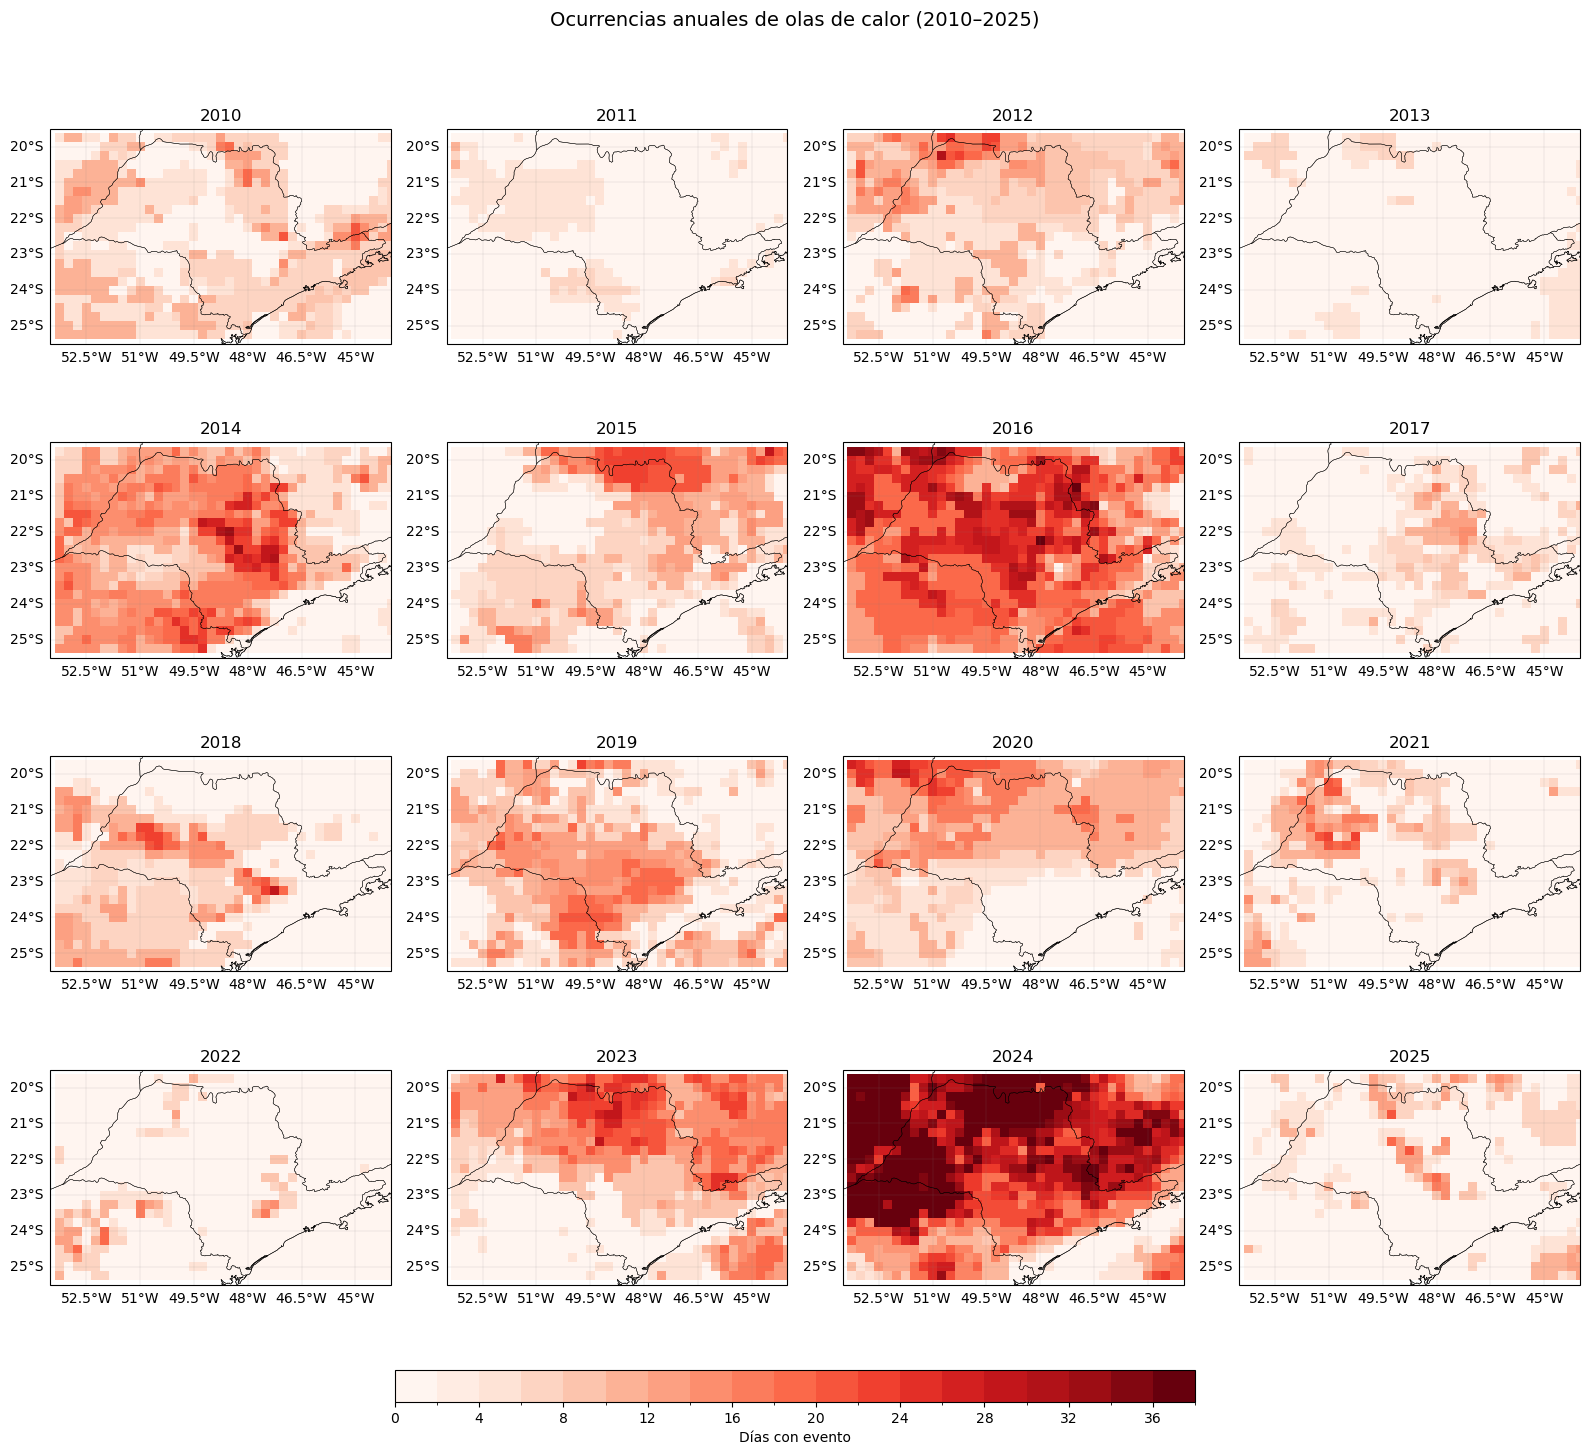

In [17]:
years = ds["year"].values
ncols = 4
nrows = int(np.ceil(len(years) / ncols))

fig, axes = plt.subplots(
    nrows, ncols, figsize=(16, nrows * 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    data = ds["event_dummy"].sel(year=year).sum(dim="valid_time")
    levels = np.arange(0, 40, 2)

    im = data.plot(
        ax=ax,
        cmap="Reds",
        levels=levels,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )    
    ax.set_title(str(year))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_extent([-53.5, -44, -25.5, -19.5])
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Días con evento")
fig.suptitle("Ocurrencias anuales de olas de calor (2010–2025)", fontsize=14, y=0.95)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

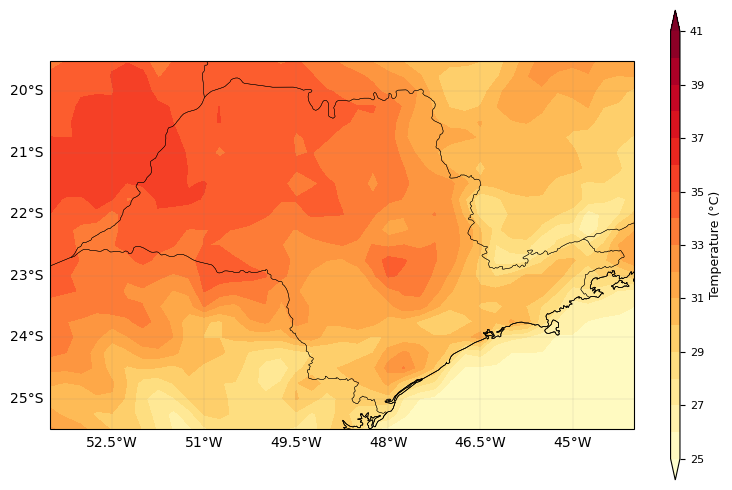

In [21]:

file_percentiles = 'tmax2m_mean_and_percentiles_2015_2024_area_6N_-74W_-34S_-33E.nc'
ds = xr.open_dataset(data_processed_dir + file_percentiles)

p98_mean = ds["t2m_p98"].mean(dim="doy")

# Graficar
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.PlateCarree()})

im = ax.contourf(
    ds.longitude, ds.latitude, p98_mean,
    levels=np.arange(25, 42, 1), cmap="YlOrRd", extend="both", transform=ccrs.PlateCarree()
)

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.3)
ax.set_extent([-53.5, -44, -25.5, -19.5])
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax.set_extent([-53.5, -44, -25.5, -19.5])

ax.tick_params(labelsize=7)

cbar = plt.colorbar(im, orientation="vertical", pad=0.05, aspect=50)
cbar.set_label("Temperature (°C)", fontsize=9)
cbar.ax.tick_params(labelsize=8)
plt.tight_layout()
# plt.savefig(f"../figures/p95_mean_1995_2024.png", dpi=400)